In [2]:
import numpy as np
import pandas as pd
import math
from itertools import chain
import matplotlib.pyplot as plt

In [3]:
def generate_vector_with_angle(reference_vector, target_angle, normalize=True):
    """
    Generate a random vector with a specific angle to the reference vector.
    
    Args:
        reference_vector: The reference vector (numpy array)
        target_angle: Desired angle in radians
        normalize: Whether to normalize the output vector
    
    Returns:
        A new vector with the desired angle to the reference vector
    """
    # Generate a random vector
    random_vector = np.random.randn(len(reference_vector))
    
    # Make it orthogonal to reference_vector
    orthogonal = random_vector - (np.dot(random_vector, reference_vector) / 
                                np.dot(reference_vector, reference_vector)) * reference_vector
    
    # Combine reference_vector and orthogonal part to get desired angle
    new_vector = (np.cos(target_angle) * reference_vector + 
                 np.sin(target_angle) * orthogonal / np.linalg.norm(orthogonal))
    
    if normalize:
        new_vector = new_vector / np.linalg.norm(new_vector)
        
    return new_vector

In [56]:
# random feature map - corresponding to phi in the paper 
def phi(h, fs, random_feats, m):
    return lambda x: (
        h(x)
        / np.sqrt(m)
        * np.concatenate(
            [f(np.einsum("...d,md->...m", x, random_feats)) for f in fs],
            axis=-1,
        )
    )

#Random features trig estimator following definition from paper
def trig_est(x,y, Gauss_random_vector):
    m = Gauss_random_vector.shape[0]
    def h(x):
        return np.exp(np.sum(x** 2, axis = 0)/2)
    phi_x = phi(h, [np.sin, np.cos], Gauss_random_vector, m)(x)
    phi_y = phi(h, [np.sin, np.cos], Gauss_random_vector, m)(y)
    
    return phi_x.T@phi_y

#Favor+ estimator following definition from paper
def favor_plus_est(x,y, Gauss_random_vector):
    def h(x):
        return np.exp(-np.square(x).sum(axis=-1, keepdims=True) / 2)
    
    m = Gauss_random_vector.shape[0]
    phi_x = phi(h, [np.exp], Gauss_random_vector, m)(x)
    phi_y = phi(h, [np.exp], Gauss_random_vector, m)(y)
    
    return phi_x.T@phi_y

def angle(x,y):
    dotproduct = np.dot(x,y)/(np.linalg.norm(x)* np.linalg.norm(y))
    angle = np.arccos(dotproduct)
    return angle

def lambda_est(x,y, Gauss_random_vector):
    def h(x):
        return 1j
    
    m = Gauss_random_vector.shape[0]
    phi_x = phi(h, [np.sign], Gauss_random_vector, m)(x)
    phi_y = phi(h, [np.sign], Gauss_random_vector, m)(y)

    return 1/2 + phi_x.T@phi_y 

def angular_hybrid_est(x,y, Gauss_random_vector):
    l = lambda_est(x,y, Gauss_random_vector)
    l = (l + 0.5)/2
    return l, l*favor_plus_est(x,y, Gauss_random_vector) + (1-l)*trig_est(x,y, Gauss_random_vector)

In [74]:
np.random.seed(0)

dim = 64
nrff = 128
R = 1
random_feats = np.random.randn(nrff, dim)

# Generate array of angles from 0 to pi
angles = np.linspace(0, np.pi, 1000)

#track squared errors for each estimator
trig_errors= []
favor_plus_errors= []
angular_hybrid_errors = []
angle_errors = []
angle_preds = []

negative_trig_preds = 0
negative_favor_preds = 0
negative_angular_hybrid_preds = 0
for a in angles:
    v1 = np.random.randn(dim)
    v1 = v1 / np.linalg.norm(v1) * R

    # Generate second vector with specified angle to first vector
    v2 = generate_vector_with_angle(v1, a)

    softmax_true = np.exp(v1@v2.T)
    
    trig_pred = trig_est(v1, v2, random_feats)
    favor_plus_pred = favor_plus_est(v1, v2, random_feats)
    l, angular_hybrid_pred = np.real(angular_hybrid_est(v1, v2, random_feats))

    if trig_pred < 0:
        negative_trig_preds += 1
    if favor_plus_pred < 0:
        negative_favor_preds += 1
    if angular_hybrid_pred < 0:
        negative_angular_hybrid_preds += 1
    # Use relative error as it brings both scales closer together and is more important
    # than absolute error for many applications of softmax kernel estimation
    rel_trig_err = abs(softmax_true - trig_pred)/softmax_true
    rel_favor_plus_err = abs(softmax_true - favor_plus_pred)/softmax_true
    rel_angular_hybrid_err = abs(softmax_true - angular_hybrid_pred)/softmax_true
    
    trig_errors.append(rel_trig_err)
    favor_plus_errors.append(rel_favor_plus_err)
    angular_hybrid_errors.append(rel_angular_hybrid_err)
    
    #check on error of angular kernel estimator
    angle_pred = l*np.pi
    angle_preds.append(angle_pred)
    angle_err = abs(a - angle_pred)/np.pi  
    angle_errors.append(angle_err)
    
    # trig_errors.append((trig_pred-softmax_true)**2)
    # favor_plus_errors.append((favor_plus_pred-softmax_true)**2)    angular_hybrid_errors.append(rel_angular_hybrid_err)        negative_favor_plus_preds += 1
    l, angular_hybrid_pred = np.real(angular_hybrid_est(v1, v2, random_feats))
    if angular_hybrid_pred < 0:
        negative_angular_hybrid_preds += 1

In [75]:
print(f"Number of negative trig predictions: {negative_trig_preds}")
print(f"Number of negative favor+ predictions: {negative_favor_preds}")
print(f"Number of negative hybrid predictions: {negative_angular_hybrid_preds}")
print(np.min(angle_preds), np.max(angle_preds))

Number of negative trig predictions: 2
Number of negative favor+ predictions: 0
Number of negative hybrid predictions: 0
1.743934249004316e-16 3.141592653589793


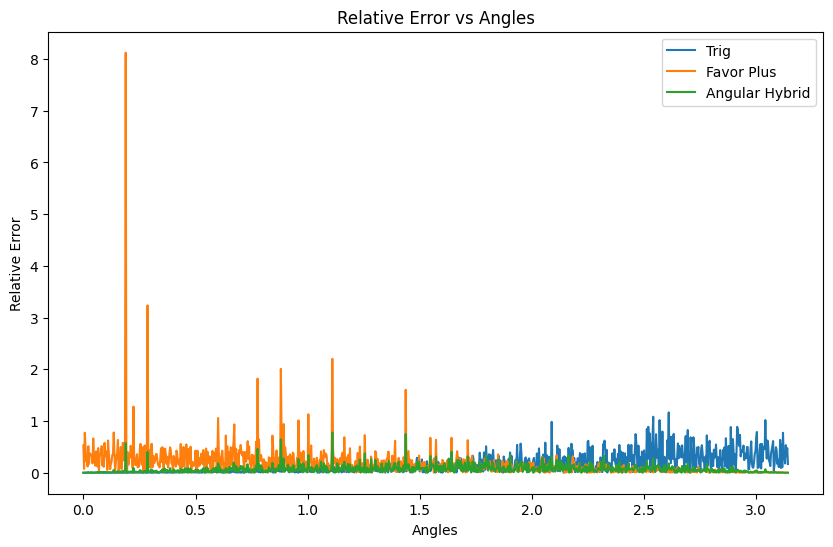

In [76]:
plt.figure(figsize=(10,6))
plt.plot(angles, trig_errors, label='Trig')
plt.plot(angles, favor_plus_errors, label='Favor Plus')
plt.plot(angles, angular_hybrid_errors, label='Angular Hybrid')
plt.xlabel('Angles')
plt.ylabel('Relative Error')
#plt.ylim([0,0.5])
plt.title('Relative Error vs Angles')
plt.legend()
plt.show()

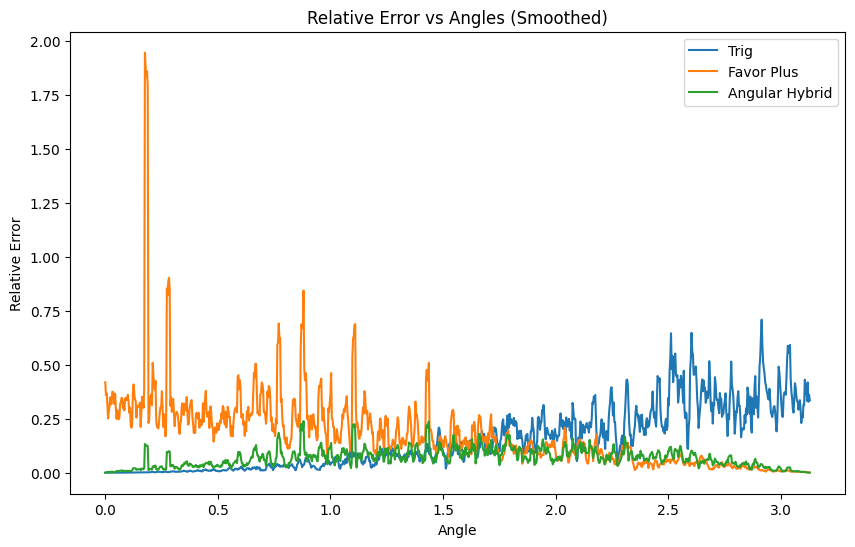

In [77]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average with a window size of 5
window_size = 5
smoothed_trig_errors = moving_average(trig_errors, window_size)
smoothed_favor_plus_errors = moving_average(favor_plus_errors, window_size)
smoothed_angular_hybrid_errors = moving_average(angular_hybrid_errors, window_size)
smoothed_angles = angles[:len(smoothed_trig_errors)]  # Adjust angles array to match the length of smoothed data

# Plot smoothed errors against angles
plt.figure(figsize=(10,6))
plt.plot(smoothed_angles, smoothed_trig_errors, label='Trig')
plt.plot(smoothed_angles, smoothed_favor_plus_errors, label='Favor Plus')
plt.plot(smoothed_angles, smoothed_angular_hybrid_errors, label='Angular Hybrid')
plt.xlabel('Angle')
plt.ylabel('Relative Error')
#plt.ylim([0, 0.8])
plt.title('Relative Error vs Angles (Smoothed)')
plt.legend()
plt.show()

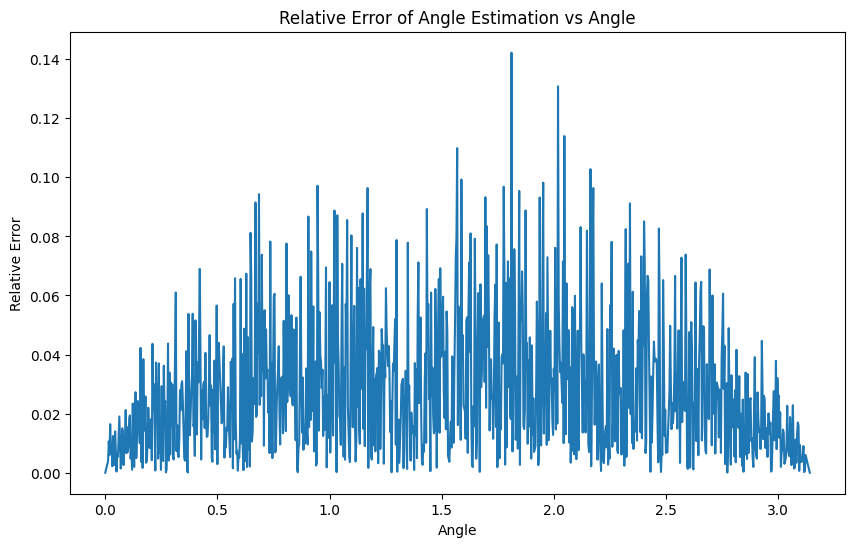

In [78]:
plt.figure(figsize=(10,6))
plt.plot(angles, angle_errors)
plt.xlabel('Angle')
plt.ylabel('Relative Error')
plt.title('Relative Error of Angle Estimation vs Angle')
plt.show()